**POINT OF THIS NOTEBOOK IS TO CORRECT MISTAKES OF PREVIOUS NOTEBOOK USING LSTM:** 

**MISTAKES OF PREVIOUS NOTEBOOK:**

**1. OVERFITTING DUE TO LIMITED DATASIZE**

**2.  EXCESSIVE FEATURE EXTRACTION**

**3. HAVING WRONG PREDICTIONS DUE TO WRONG TYPE OF NORMALIZATION**

**4. NO HYPERPARAMTER TUNING**

**. TRYING TO PREDICT STOCK PRICES. WE FOUND OUT LSTMs ARE BETTER ARE DETECTING STOCK PRICE MOVEMENTS**

**THIS NOTEBOOK IS DEALING WITH ALL THESE PROBLEMS WITH THE FOLLOWING STEPS:**

**1.GETTING DATA FROM THE API AND SETTING UP COLAB**

**2. PLOTTING THE DATA**

**3. NORMALIZING THE DATA**

**4. FIND OUT MORE ABOUT THE DATA-EMA, MOVING AVERAGES, ONE STEP AHEAD PREDICTION**

**5. HYPERPARAMETER TUNING**

**6. CREATE AN AVERAGE PRICE AND USE THAT TO CREATE TRAINING AND TESTING DATA**

**7. TRAIN AN LSTM NETWORK**

**8. PLOT THE PREDICTIONS**

**9. EXPERIMENT AROUND WITH HYPERPARAMETERS, TRAINING AND SEE IF YOU ARE OVERFITTING OR UNDER FITTING**

**10. CONCLUSION**


**PART 1: SETTING UP COLAB.** 

In [0]:
#import libraries
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

In [40]:
#declare name of your device and drive location select GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [41]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


**SO I THOUGHT OF USING GENERAL ELECTRIC(GE) DATA INSTEAD OF AMAZON FOR THIS RUN.**

**THE DATASET IS LARGER AND ITS EASIER TO OBSERVE THEIR PROGRESS FOR LONGER TIME THAN AMAZON.AMAZON HAS BEEN AROUND FOR NOT A LONG TIME SO IT GETS TOUGHER TO CORRELATE BETWEEN TESTING DATA AND TRAINING DATA.EXAMPLE** 

**IF I NEED 900 DATA SAMPLES FOR TRAINING ILL HAVE TO RUN TESTING ON 180 DAYS BUT THE RISE ON AMAZON HAS BEEN AROUND FOR 4 YEARS(IN ALL 1200 DAYS) TO THIS DATE SO DATA IS LIMITED ESPECIALLY FOR THIS KIND OF ONE DAY PREDICTION AND PRICE PATTERN PREDICTION**

**DATASET IS LARGER THIS TIME AROUND SO I DONT HAVE TO WORRY ABOUT OVERFITTING AND CAN FOCUS MORE ON THE TRAINING**



In [0]:
#name of your google path
googlepath = "/content/drive/My Drive"

In [0]:
#Get your API data
df = pd.read_csv(os.path.join(f'{googlepath}','ge.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])

In [44]:
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


**FIND AVERAGE PRICE OF THE HIGH AND LOW PRICES AND USE THAT TO PLOT.**

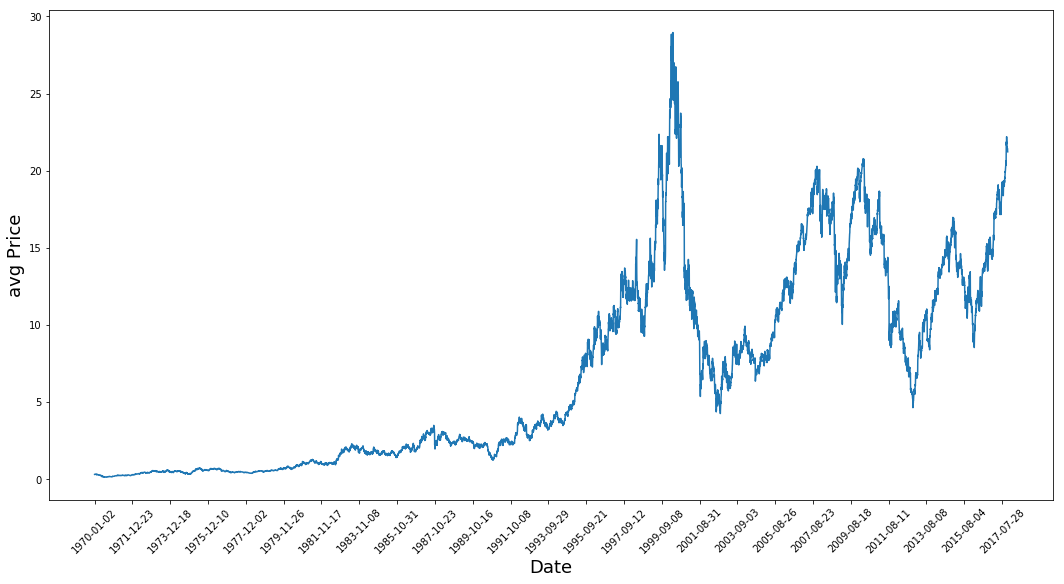

In [45]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('avg Price',fontsize=18)
plt.show()

In [46]:
# First calculate the average prices from the highest and lowest 
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
avg_prices = (high_prices+low_prices)/2.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


**OBSERVATIONS FROM THE PLOT:;**

**1. DATA PEAKS AROUND 1983 AND THEN GROWS UNTIL TWO CRASHES *ONE AROUND 2001(JUST AROUND 9/11 AND THE SECOND AROUND THE 2009 FINANCIAL MARKET CRASH.*.THIS IS REALLY INTERESTING!)**

**2. CALCULATING AVERAGE PRICES IS SOMEHOW NORMALIZING THE DATA AND GIVING A MUCH BETTER PICTURE THAN USING ONLY HIGH PRICES OR CLOSING PRICES SINCE IT GIVES AN IDEA ABOUT BUSINESS AROUND THE FULL DAY.**

**DATASET SIZE IS AROUND 12000 DATAPOINTS.** 

**SPLIT AVERAGE DATASET BETWEEN 11000 DATAPOINTS ARE IN TRAINING AND REST IN TESTING.**

**TRAINING DATASET IS  THEN NORMALIZED**

In [47]:
train = avg_prices[:11000]
test = avg_prices[11000:]
len(avg_prices)

12075

**START NORMALIZING DATA BY SCALING IT.**

**PROCESS OF NORMALIZATION:**

**1. CREATE  A WINDOW AND A USE THAT TO SMOOTHEN TTHE DATA POINTS'**

**2. USING A WINDOW OF 2500 FOR 10000 DATAPOINTS WOULD CREATE 4 DISTINCT DATAPOINTS**

**3. THE LAST NORMALIZATION SMOOTHS OVER THE REMAINING DATA POINTS**

**4. MinMaxScalar SCALES ALL THE  DATA TO BE IN THE REGION OF 0 AND 1.**

**You can also reshape the training and test data to be in the shape**


**PROCEDURE**

**Due to the observation you made earlier, that is, different time periods of data have different value ranges, you** **normalize the data by splitting the full series into windows. If you don't do this, the earlier data will be close to 0 and will not add much value to the learning process. Here you choose a window size of 2500.**

Ref: https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

In [0]:
scaler = MinMaxScaler() #use mimaxscaler from scikitlearn to normalize data
train = train.reshape(-1,1)
test = test.reshape(-1,1)


**NORMALIZE AVERAGE PRICES AND TRY TO PREDICT BASED ON THEM INSTEAD OF FEATURE GENERATION**
**Length of data is 12075..we can normalize it using the sliding window technique.**

In [0]:
window_size = 2500
for x in range(0,10000,window_size):
    scaler.fit(train[x:x+window_size,:])
    train[x:x+window_size,:] = scaler.transform(train[x:x+window_size,:])

scaler.fit(train[x+window_size:,:])
train[x+window_size:,:] = scaler.transform(train[x+window_size:,:])

In [0]:
# Reshape both train and test data
train = train.reshape(-1)

**make this into a 2d shape train**

In [0]:
# Normalize test data
test = scaler.transform(test).reshape(-1)

**If you observe we never scale down the test data but instead just transform it and then reshape into the same shape of train data.** 
**You can now smooth the data using the exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.**

**You should only smooth training data.**

Ref:https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well

# EMA averaging

In [0]:
EMA = 0.0 # keep EMA 0.0
ema2 = 0.1 # gamma is a variabe that can be multiplied with train 
for i in range(11000):
  EMA = ema2*train[i] + (1-ema2)*EMA
  train[i] = EMA

In [0]:
# Used for visualization and test purposes
all_avg_data = np.concatenate([train,test],axis=0)

# One-Step Ahead Prediction via Averaging

What is One Step Ahead Prediction? 

Generally, time series forecasting describes predicting the observation at the next time step.

This is called a one-step forecast, as only one time step is to be predicted.

Mathematics behind it:

One step ahead prediction is prediction of one more day if past series values are give. In our case we average all the data and then try finding the next day's average value. To find this we train the data and find te pattern to get an output y. 
This process goes on for as  long as you select your training data.

Averaging mechanisms allow you to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. You will look at two averaging techniques below; standard averaging and exponential moving average. You will evaluate both qualitatively (visual inspection) and quantitatively (Mean Squared Error) the results produced by the two algorithms.

The Mean Squared Error (MSE) can be calculated by taking the Squared Error between the true value at one step ahead and the predicted value and averaging it over all the predictions.


Ref: https://machinelearningmastery.com/multi-step-time-series-forecasting/



**Simple Averaging:**

You can understand the difficulty of this problem by first trying to model this as an average calculation problem. First you will try to predict the future stock market prices (for example, xt+1) as an average of the previously observed stock market prices within a fixed size window (for example, xt-N, ..., xt) (say previous 100 days). Thereafter you will try a bit more fancier "exponential moving average" method and see how well that does. Then you will move on to the "holy-grail" of time-series prediction; Long Short-Term Memory models.

First you will see how normal averaging works. That is you say,
![alt text](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1525377205/sum_formula.png)

In other words, you say the prediction at t+1 is the average value of all the stock prices you observed within a window of t to t−N.

Ref: https://data36.com/statistical-averages-mean-median-mode/

In [54]:
window_size = 100 # chose standard window size of 100
N = train.size
mse_err = []
_avg_pred = [] #create a list for average x, predictions and mse errors
_avg_x = []

for idx1 in range(window_size,N): #make a for loop where if the value is greater than size then use timedelta function for that 1 day
    
    if idx1 >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[idx1,'Date']  #if not just find that value in the dataframe for the data and put it in date
        
    _avg_pred.append(np.mean(train[idx1-window_size:idx1])) #Keep apending values into into the lists
    mse_err.append((_avg_pred[-1]-train[idx1])**2)   #calculate mse errors
    _avg_x.append(date) #this is the x train for averages we will use to train 

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_err)))

MSE error for standard averaging: 0.00418


for range from 100 to size of train(11000) create the training data dates and then find their mean and append them to average predictions
else: 
make a test set and then append all this to std_avg(all dates in this)
and:
calculate the mse_err

The above method is super awesome to calculate simple or standard averages. It uses timedelta to mainpulate date and push the date back to 1 day and add it to date along with datetime which strups the date and time from the given format. 

The above code will execute only when idx1 is greater than size(so all testing data is stored differently and training data is different)

Ref: https://machinelearningmastery.com/normalize-standardize-time-series-data-python/


MSE error is great! Very less just as we were expecting. 

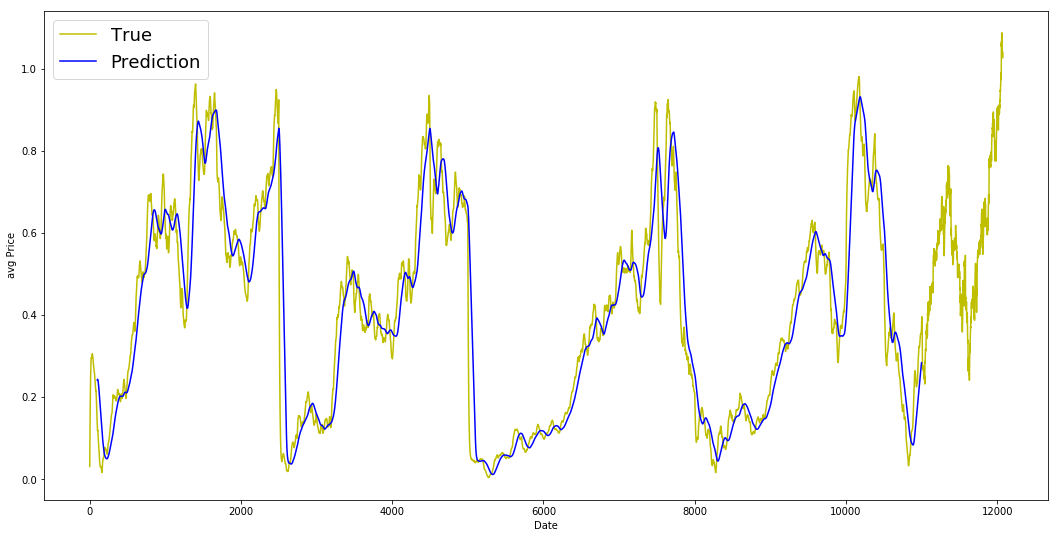

In [55]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_avg_data,color='y',label='True')
plt.plot(range(window_size,N),_avg_pred,color='b',label='Prediction')
plt.xlabel('Date')
plt.ylabel('avg Price')
plt.legend(fontsize=18)
plt.show()

**WOW! IT WORKED! COMPARE THIS WITH THE NORMALIZTION TECHNIQUE USED IN THE PREVIOUS NOTEBOOK COMBINED WITH THE SIMPLE AVERAGING STRATERGY. WE GET A GREAT 1ST** **PREDICTION!**

Ref: https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/

**Now lets Exponential Moving Average similar to what we had tried before.**

**Exponential Moving Average**

**'We are using EMA to calculate the next prediction step.**'

**It's given by the formula:**

**xt+1 = EMAt = γ × EMAt-1 + (1-γ) xt where EMA0 = 0 and EMA is the exponential moving average value you maintain over time.**

**This formula helps to find prediction in t+1 step ie one step prediction. Because you take only a very small fraction of the most recent, it allows to preserve much older values you saw very early in the average. See how good this looks when used to predict one-step ahead below.**



In [56]:
window_size = 100
N = train.size
mse_err = []
_avg_predictions_run = []
_avg_x_run = []



running_mean = 0.0 #the mean tat is calculates
_avg_predictions_run.append(running_mean) 

decay = 0.5 # use this to average the running mean again; 

for idx1 in range(1,N): #range from 1 to N-1
     
    running_mean = running_mean*decay + (1.0-decay)*train[idx1-1] #the remaining prob multiplied by the train sets data points
    _avg_predictions_run.append(running_mean)
    mse_err.append((_avg_predictions_run[-1]-train[idx1])**2) #make mse error with the help of train set
    _avg_x_run.append(date) #append the dates into the list

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_err))) #Calculate MSE

MSE error for EMA averaging: 0.00003


**MSE is great for EMA much better than simple average**

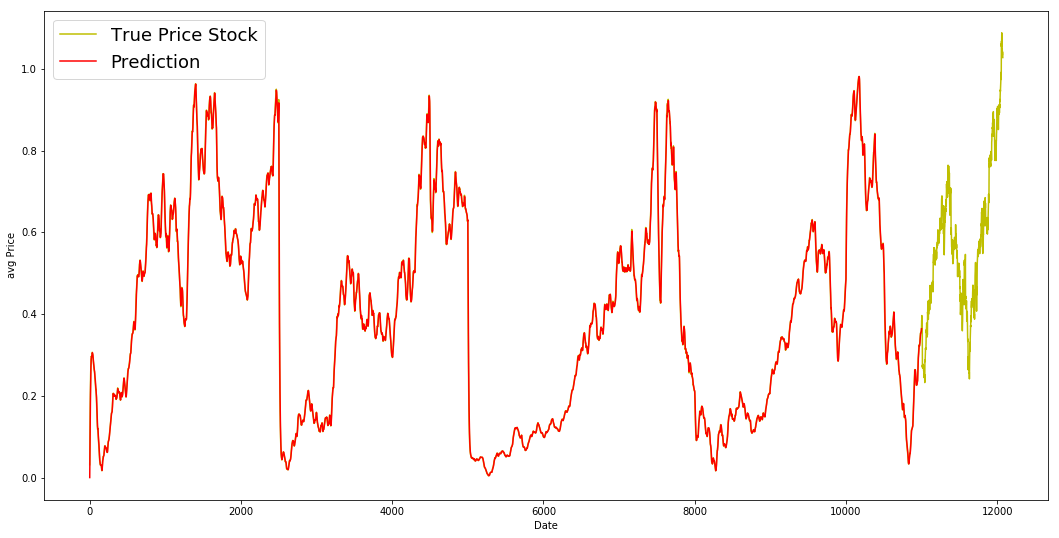

In [57]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_avg_data,color='y',label='True Price Stock')
plt.plot(range(0,N),_avg_predictions_run,color='r', label='Prediction')
plt.xlabel('Date')
plt.ylabel('avg Price')
plt.legend(fontsize=18)
plt.show()

**EMA is a great model for this dataset. Ideally the pattern of the True data should have been followed in the prediction model.** 

**We coded  from range to 1 to N-1 and put all the averaged values in the running mean. We used dense as 0.5 and then multiply it with the running average.** 

**Have a good read at bellow reference**

**Let's move on to LSTM**

ref:https://traderhq.com/moving-average-trading-strategies-do-they-work/

# LSTM

**Steps in LSTM:**

**1. Generate data so that stock price movements can be predicted**

**2. Augument data**

**3. Define Hyperparameters**

**'4. Make of Input and Output**

**5. Define Parameters of the LSTM and Regression Layer**

**6. Find LSTM Ouptut**

**7. Get final prediction from logistic regression layer'**

**8. Calculate loss and Optimixer**

**9. Train the LSTM model**

**10. Calculate predictions and plot it**

# 1 : Generate the stock price movements to input into LSTM 

The below method generates data and puts it in form of batches of the size of the batch size:
1. generate data and labels
2. generate simple full length data and labels and make an array for indices using closing prices
3. use this generated rolled out batches as input for LSTM 
4. the input will be the data and output will be the labels based on the prices

Logic: 
1. Create a batch size for the sequence of data that we have
2. Use this batch size on the seq and keep rolling out ie converting the data into small batches of the batch size
3. Put all this in a for loop in unroll method and roll out all the batches
4. Keep the input as data and the output as labels

Ref: https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/

In [58]:
class Generator(object):   
    
    def __init__(self,prices,batch_size,num_unroll): #helps to generate data 
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next(self):   #which will output a set of num_unrollings batches of input data obtained sequentially, where a batch of data is of size [batch_size, 1]. 
        
        batch_data = np.zeros((self._batch_size),dtype=np.float32)  #Then each batch of input data will have a corresponding output batch of data.
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
        for b in range(self._batch_size):   #create batches 
            if self._cursor[b]+1>=self._prices_length:
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
                
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
            
        return batch_data,batch_labels
    
    def unroll(self):   #roll out the batches generated in form of data and labels 
            
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            
            data, labels = self.next()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self): #get prices length 
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
        


dg = Generator(train,5,5)
u_data, u_labels = dg.unroll()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)




Unrolled index 0
	Inputs:  [0.03143791 0.6904868  0.82829314 0.32585657 0.11600105]

	Output: [0.11098009 0.6848606  0.83294916 0.33355275 0.12106793]


Unrolled index 1
	Inputs:  [0.06067836 0.6890754  0.8325337  0.32857886 0.11785509]

	Output: [0.132895   0.6848606  0.833369   0.33421066 0.12192084]


Unrolled index 2
	Inputs:  [0.08698314 0.68685144 0.8329321  0.33078218 0.11946969]

	Output: [0.132895   0.6848606  0.833141   0.33355275 0.12158521]


Unrolled index 3
	Inputs:  [0.11098009 0.6858036  0.83294916 0.33219692 0.12106793]

	Output: [0.17132245 0.6820074  0.833369   0.33355275 0.12230608]


Unrolled index 4
	Inputs:  [0.132895   0.6848606  0.833369   0.33355275 0.12158521]

	Output: [0.17132245 0.6836884  0.83387965 0.33650374 0.12358698]


# 2: Tweaking Hyperparameters

Let's tweak hyperparameters so we get better results for the neural net. 

D is the dimensionality which is 1. We have a 1d input and will get a simila output

num_unrollings deals with the BPTT of the net. It helps to tune the net by looking back that many layers and tuning weights

batchsize is how many datapoints are taken in a batch 

num_nodes is the number of nodes in each cell and layers is the length of theses number of nodes

Have a good look at the tensorflow docx

Ref : https://www.tensorflow.org/api_docs/python/tf/layers/Dense


In [0]:
D = 1 # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

**SPLIT THE TRAIN INTO INPUT AND OUTPUT AND DEFINE THEM. DECLARE DEMENSIONALITY OF THE TRAIN. INPUT IS 1 AND OUTPUT IS 1. BATCHSIZE IS A 1D TUPLE. SHAPE GIVEN TO LSTM IS [(BATCHSIZE), DIM]  WHICH IS 3 FIELDS**

In [0]:
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


**DECLARE A SINGLE LSTM CELL USE TENSORFLOW DOCUMENTATION**

In [0]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

**THE NEXT STEPS ARE BASICALLY CREATING TRANSFORMATION, CALCULATING LOSS AND DEFINING LOSS AND THEN FINALLY TRAIN THE LSTM CODE CAN BE FOUND IN BELOW TENSORFLOW LINKS**

Code:

https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn

https://www.tensorflow.org/api_docs/python/tf/train/Optimizer

https://www.tensorflow.org/api_docs/python/tf/reshape

https://www.tensorflow.org/api_docs/python/tf/control_dependencies



In [0]:
# Create cell state and hidden state variables to maintain the state of the LSTM
a1, b1 = [],[]
initial_state = []
for li in range(n_layers):
  a1.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  b1.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(a1[li], b1[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. 
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [63]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps
print('Loss for the input train while converting prices into movements')
loss = 0.0
with tf.control_dependencies([tf.assign(a1[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(b1[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ =  tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))



Loss for the input train while converting prices into movements
Learning rate decay operations
TF Optimization operations


**MAKE SAMPLE PREDICTIONS FOR THE ABOVE MODEL:**

Check code out for https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn so that we can get a sample output and state . Then run a model on this code https://www.tensorflow.org/api_docs/python/tf/nn/xw_plus_b and predict

I also took help of this github repo: 
https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction/blob/master/core/model.py

In [64]:
 print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


**CREATE A TRAINING MODEL, THEN VALIDATE MODEL AND TEST IT AND PREDICT IT. AGAIN CODE IS FOUND IN TENSORFLOW DOCCUMENTATION**

In [65]:
epochs = 50
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = Generator(train,batch_size,num_unrollings) 

x_axis_seq = []

# Points you start our test predictions from
test_points_seq = np.arange(11000,12000,50).tolist() 

for ep in range(epochs):       
    
    #Training
    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
    
    #Validation
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
      
      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 # reset loss
      
      predictions_seq = []
      
      mse_test_loss_seq = []
      
      #Updating State and Making Predicitons
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []
        
        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]
        
        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_avg_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = all_avg_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_avg_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)
        
        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_loss_seq)
      
      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 1.606525
	Test MSE: 0.01014
	Finished Predictions
Average loss at step 2: 0.176963
	Test MSE: 0.00842
	Finished Predictions
Average loss at step 3: 0.080844
	Test MSE: 0.00311
	Finished Predictions
Average loss at step 4: 0.066810
	Test MSE: 0.00270
	Finished Predictions
Average loss at step 5: 0.055696
	Test MSE: 0.00270
	Finished Predictions
Average loss at step 6: 0.052513
	Test MSE: 0.00345
	Finished Predictions
Average loss at step 7: 0.052445
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 8: 0.046246
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 9: 0.050750
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 10: 0.043253
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 11: 0.040725
	Test MSE: 0.00273
	Finished Predictions
Average loss at step 12: 0.039212
	Test MSE: 0.00238
	Finished Predictions
Average loss at step 13: 0.036308
	Test MSE: 0.00239
	Finished Predictions
Average loss at step 1

**PLOT TENSORFLOW PREDICTIONS PLOT**

**Code reference: https://www.tensorflow.org/beta/tutorials/text/time_series**

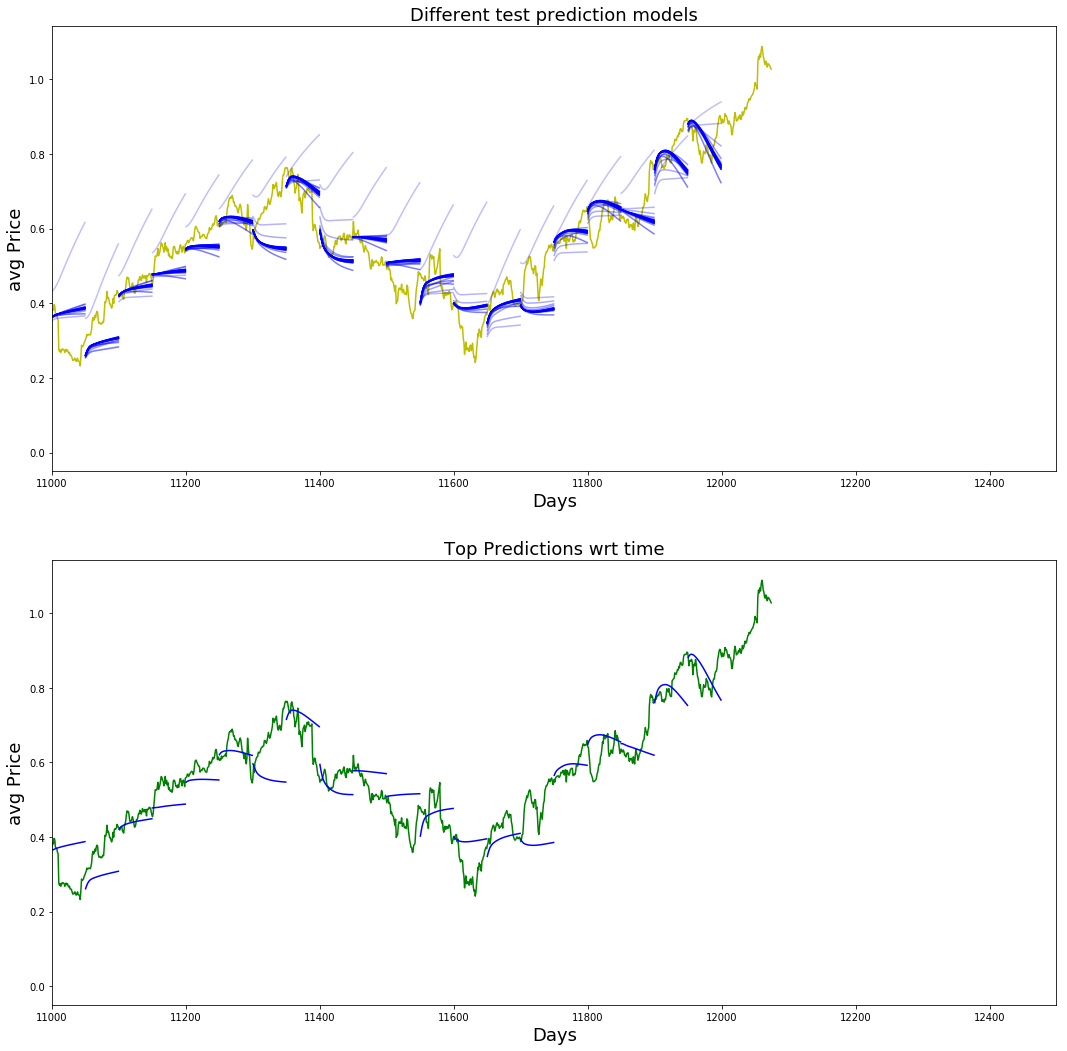

In [66]:
best_prediction_epoch = 49 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_avg_data,color='y',label='data')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='b',alpha=alpha[p_i],label='stock price movement change')

plt.title('Different test prediction models',fontsize=18)
plt.xlabel('Days',fontsize=18)
plt.ylabel('avg Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_avg_data,color='g',label='predictions')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='b',label='change in price movement')
    
plt.title('Top Predictions wrt time',fontsize=18)
plt.xlabel('Days',fontsize=18)
plt.ylabel('avg Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()

**CONCLUSIONS AND INTERPRETATION OF THE ABOVE PLOT:**

**NOTICE THAT WE PREDICT STOCK PRICE MOVEMENTS AND NOT STOCK PRICE OVER TIME**

**THE BLUE TICKS INDICATE CHANGES IN THE STOCK PRICE MOVEMENT IE THIER MOMENTUM**

**THIS IS CALCULATED BY SPLITTING THE UNROLL SEQUENCE GENERATOR**

**THE Y AXIS IS BETWEEN 0 AND 1 AND ALL PRICE MOVEMENTS ARE BETWEEN THEM**

**ANYTHING ABOVE .8 AND CLOSE TO 1 IS A GOOD VALUE**

**GENERALLY OVER A LONGER TIME LSTM CAN DETECT STOCK PRICE MOVEMENTS MUCH BETTER THAN IT CAN DETECT STOCK PRICES EASILY AS SEEN**

 



**Make a generator sequence again**

In [0]:
class Generator(object):   
    
    def __init__(self,prices,batch_size,num_unroll): #helps to generate data 
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next(self):   #which will output a set of num_unrollings batches of input data obtained sequentially, where a batch of data is of size [batch_size, 1]. 
        
        batch_data = np.zeros((self._batch_size),dtype=np.float32)  #Then each batch of input data will have a corresponding output batch of data.
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
        for b in range(self._batch_size):   #create batches 
            if self._cursor[b]+1>=self._prices_length:
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
                
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
            
        return batch_data,batch_labels
    
    def unroll(self):   #roll out the batches generated in form of data and labels 
            
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            
            data, labels = self.next()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self): #get prices length 
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
        


dg = Generator(train,5,5)
u_data, u_labels = dg.unroll()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)




Unrolled index 0
	Inputs:  [0.31437907 0.68251073 0.8827639  0.34908384 0.12648556]

	Output: [0.32384238 0.67637324 0.8365174  0.34575522 0.13545202]


Unrolled index 1
	Inputs:  [0.32384238 0.67637324 0.87069887 0.35307965 0.1345414 ]

	Output: [0.33012915 0.67637324 0.8365174  0.34492955 0.1340011 ]


Unrolled index 2
	Inputs:  [0.32372627 0.6668353  0.8365174  0.35061213 0.1340011 ]

	Output: [0.33012915 0.6731387  0.831089   0.34013176 0.1262407 ]


Unrolled index 3
	Inputs:  [0.32695258 0.67637324 0.83310276 0.34492955 0.13545202]

	Output: [0.33012915 0.6731387  0.83714783 0.35714167 0.12494157]


Unrolled index 4
	Inputs:  [0.33012915 0.67637324 0.83714783 0.34575522 0.1262407 ]

	Output: [0.3396588  0.6731387  0.8405274  0.35714167 0.12577325]


**RUN ANOTHER MODEL CHANGING HYPERPARAMETER AND EPOCH**



**Change hyperparamters**

In [0]:
D = 1 # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 75
batch_size = 300
num_nodes = [250,250,175] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [0]:
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


In [0]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [0]:
# Create cell state and hidden state variables to maintain the state of the LSTM
a1, b1 = [],[]
initial_state = []
for li in range(n_layers):
  a1.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  b1.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(a1[li], b1[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. 
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [0]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps
print('Loss for the input train while converting prices into movements')
loss = 0.0
with tf.control_dependencies([tf.assign(a1[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(b1[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ =  tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))



Loss for the input train while converting prices into movements
Learning rate decay operations
TF Optimization operations


In [0]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)


Defining prediction related TF functions


**Training with 100 epochs**

In [0]:
epochs = 100
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = Generator(train,batch_size,num_unrollings) 

x_axis_seq = []

# Points you start our test predictions from
test_points_seq = np.arange(11000,12000,50).tolist() 

for ep in range(epochs):       
    
    #Training
    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
    
    #Validation
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
      
      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 # reset loss
      
      predictions_seq = []
      
      mse_test_loss_seq = []
      
      #Updating State and Making Predicitons
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []
        
        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]
        
        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_avg_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = all_avg_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_avg_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)
        
        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_loss_seq)
      
      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 1.592642
	Test MSE: 0.00265
	Finished Predictions
Average loss at step 2: 0.147820
	Test MSE: 0.00486
	Finished Predictions
Average loss at step 3: 0.120285
	Test MSE: 0.00269
	Finished Predictions
Average loss at step 4: 0.117821
	Decreasing learning rate by 0.5
	Test MSE: 0.00275
	Finished Predictions
Average loss at step 5: 0.110326
	Test MSE: 0.00231
	Finished Predictions
Average loss at step 6: 0.093360
	Test MSE: 0.00260
	Finished Predictions
Average loss at step 7: 0.094030
	Test MSE: 0.00310
	Finished Predictions
Average loss at step 8: 0.094284
	Decreasing learning rate by 0.5
	Test MSE: 0.00246
	Finished Predictions
Average loss at step 9: 0.095949
	Test MSE: 0.00246
	Finished Predictions
Average loss at step 10: 0.085950
	Test MSE: 0.00279
	Finished Predictions
Average loss at step 11: 0.084883
	Decreasing learning rate by 0.5
	Test MSE: 0.00235
	Finished Predictions
Average loss at step 12: 0.092206
	Test MSE: 0.00257
	Finished Prediction

**Plot the predictions**

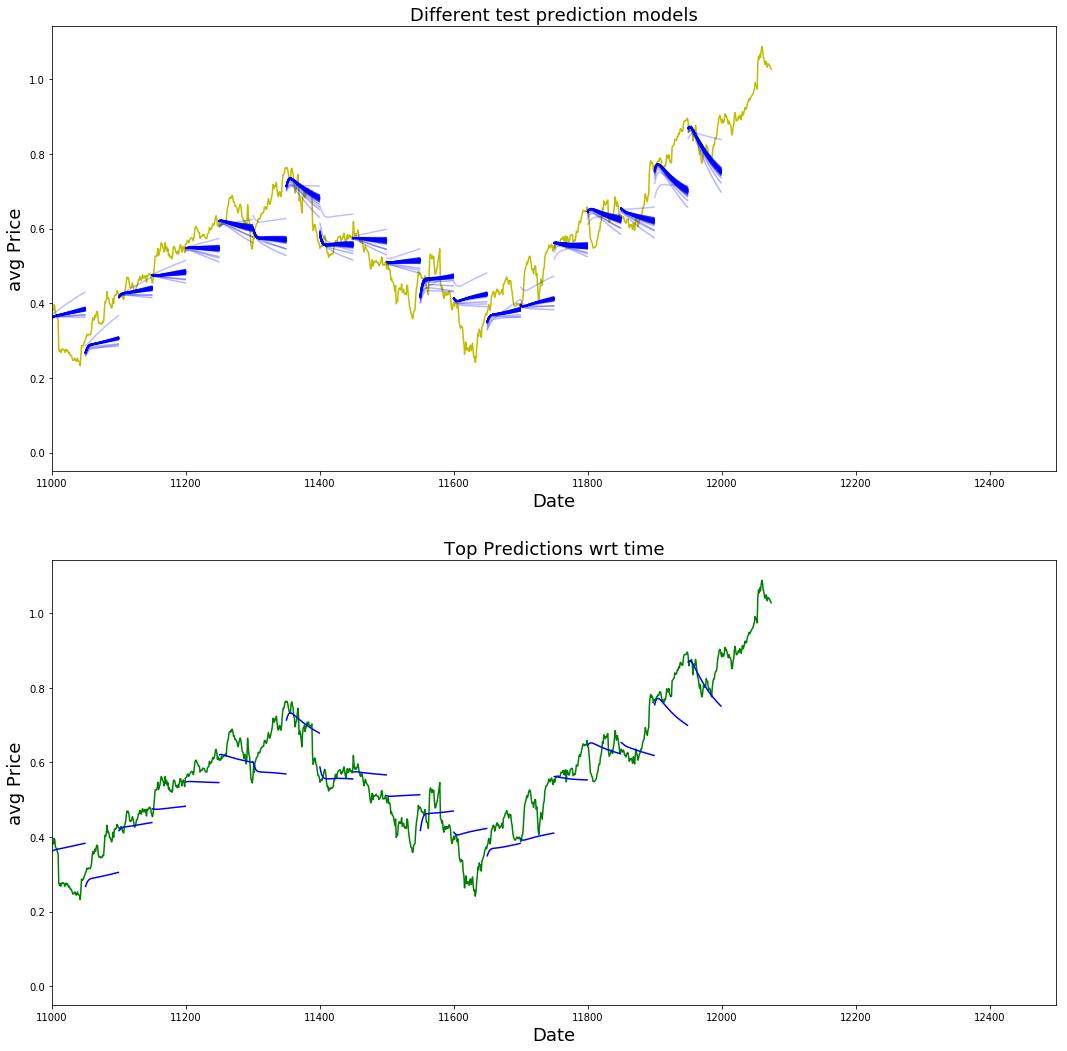

In [0]:
best_prediction_epoch = 49 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_avg_data,color='y')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='b',alpha=alpha[p_i])

plt.title('Different test prediction models',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('avg Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_avg_data,color='g')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='b')
    
plt.title('Top Predictions wrt time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('avg Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()

# **CONCLUSION:**

**Looks like when we perform hyperparameter tuning, generate a data sequence for price prediction of data instead of simply feeding prices into the LSTM network the LSTM model gives good results!**

**The model isn't underfit or overfit**

**It becomes easy to predict the movement of prices by using batch sizes and then normalization**

**After reading a few more papers I realised that trying LSTMs out with sentimental analysis- ie news feed or twitter sentiments give a better prediction. Some of the papers are listed below.**

**Papers that talk about stock market prediction with sentimenal analysis**:





1.   Stock Movement Prediction from Tweets and Historical Prices by Yumo Xu and Shay B. Cohen 

2.   Stock Prediction Using Twitter Sentiment Analysis by Anshul Mittal and Arpit Goel Stanford University

3. Sentiment Analysis for Effective Stock Market Prediction by Shri Bharthi and Angelina Geetha

